In [ ]:
#!pip install tensorflow-gpu==2.3

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GRU,Embedding,Flatten
from tensorflow.keras.models import Model
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib as plt
from joblib import dump, load

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
uploaded=files.upload()

Saving prepared_data.csv to prepared_data.csv


In [3]:
data=pd.read_csv('prepared_data.csv')
data.head()

,SMS_TEXT,ENGLISH_TEXT
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [4]:
def preprocessing_steps(data):
    """Applying the length on both sms_text and english_text and filtering the sentences based on length 
    adding start token and end token for inputs and output dataframe
    \t-> start token which represents start of the sentence
    \n-> end token which represents end of the sentence.
    Removing the sms_length, english_length, and ENGLISH_TEXT and appending ENGLISH_INPUT,ENGLISH_OUTPUT for the decoder."""
    data['sms_length']=data['SMS_TEXT'].apply(len)
    data['eng_length']=data['ENGLISH_TEXT'].apply(len)
    data=data[data['sms_length']<=170]
    data=data[data['eng_length']<=200]
    data['ENGLISH_INPUT']='\t '+data['ENGLISH_TEXT'].astype(str)
    data['ENGLISH_OUTPUT']=data['ENGLISH_TEXT'].astype(str)+' \n'
    data=data.drop(['sms_length','eng_length','ENGLISH_TEXT'],axis=1)
    return data



In [5]:
preprocessed_data=preprocessing_steps(data)
print(preprocessed_data.shape)
preprocessed_data.iloc[0]['ENGLISH_INPUT']=str(preprocessed_data.iloc[0]['ENGLISH_INPUT'])+' \n'
preprocessed_data.iloc[0]['ENGLISH_OUTPUT']=str(preprocessed_data.iloc[0]['ENGLISH_OUTPUT'])+' \n'

(1993, 3)


In [ ]:
preprocessed_data.head()

,SMS_TEXT,ENGLISH_INPUT,ENGLISH_OUTPUT
0,"U wan me to ""chop"" seat 4 u nt?",\t Do you want me to reserve seat for you or n...,Do you want me to reserve seat for you or not?...
1,Yup. U reaching. We order some durian pastry a...,\t Yeap. You reaching? We ordered some Durian ...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,\t They become more expensive already. Mine is...,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,\t I'm Thai. What do you do?,I'm Thai. What do you do? \n
4,Hi! How did your week go? Haven heard from you...,\t Hi! How did your week go? Haven't heard fro...,Hi! How did your week go? Haven't heard from y...


In [6]:
from sklearn.model_selection import train_test_split
train_data,test_data= train_test_split(preprocessed_data,test_size=0.01, random_state=42)
print(train_data.shape)
print(test_data.shape)

(1973, 3)
(20, 3)


In [7]:
tokenizer = Tokenizer(filters=None,char_level=True,lower=False)
print("SMS_TEXT")
tokenizer.fit_on_texts(train_data['SMS_TEXT'].values)
print("English text")
tokenizer_e = Tokenizer(filters=None,char_level=True,lower=False)
tokenizer_e.fit_on_texts(train_data['ENGLISH_INPUT'].values)

SMS_TEXT
English text


In [8]:
encoder_vocab_size=len(tokenizer.word_index.keys())
print(encoder_vocab_size)
decoder_vocab_size=len(tokenizer_e.word_index.keys())
print(decoder_vocab_size)

103
92


In [9]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
 
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        self.inp_vocab_size=inp_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
 
        #Initialize Embedding layer
 
        #Intialize Encoder LSTM layer
        super().__init__()
        self.Embedding_Layer=tf.keras.layers.Embedding(input_dim=self.inp_vocab_size,output_dim=self.embedding_size,input_length=input_length,mask_zero=True,name="Encoder_Embedding")
        self.LSTM_Layer=tf.keras.layers.LSTM(self.lstm_size,return_state=True,return_sequences=True,name="Encoder_LSTM")
 
    def call(self,input_sequence,states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_embedd=self.Embedding_Layer(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.LSTM_Layer(input_embedd)
     
      return self.lstm_output,self.lstm_state_h,self.lstm_state_c
 
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      intial_hidden_state=np.zeros((batch_size,self.lstm_size))
      intial_cell_state=np.zeros((batch_size,self.lstm_size))
      return intial_hidden_state,intial_cell_state

In [10]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    self.scoring_function=scoring_function
    self.att_units=att_units 
    super().__init__()
 
    # Please go through the reference notebook and research paper to complete the scoring functions
 
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
 
      
      
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.W=tf.keras.layers.Dense(att_units)
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.W1 = tf.keras.layers.Dense(att_units)
      self.W2 = tf.keras.layers.Dense(att_units)
      self.V = tf.keras.layers.Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        
        
        scoring=tf.matmul(encoder_output,tf.expand_dims(decoder_hidden_state,axis=-1))
        
        attention_weight=tf.nn.softmax(scoring,axis=1)
        
        context_vector=attention_weight*encoder_output
        context_vector=tf.reduce_sum(context_vector,axis=1)
        return context_vector,attention_weight
              
        
        
        
 
        
    elif self.scoring_function == 'general':
        # Implement General score function here
        
        score=tf.matmul(self.W(encoder_output),tf.expand_dims(decoder_hidden_state,axis=-1))
        attention_weight=tf.nn.softmax(score,axis=1)
        context_vector=attention_weight*encoder_output
        context_vector=tf.reduce_sum(context_vector,axis=1)
        return context_vector,attention_weight
    
    elif self.scoring_function == 'concat':
        # Implement General score function here
        score = self.V(tf.nn.tanh(self.W1(encoder_output) + self.W2(tf.expand_dims(decoder_hidden_state,axis=1))))
        attention_weight=tf.nn.softmax(score,axis=1)
        context_vector=attention_weight*encoder_output
        context_vector=tf.reduce_sum(context_vector,axis=1)
        return context_vector,attention_weight

In [11]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      self.tar_vocab_size=tar_vocab_size
      self.embedding_dim=embedding_dim
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units
      super().__init__()
      self.DEmbedding=tf.keras.layers.Embedding(input_dim=self.tar_vocab_size,output_dim=self.embedding_dim,input_length=self.input_length,mask_zero=True,name="Decoder_Embedding", trainable=False)
      self.DLSTM_Layer=tf.keras.layers.LSTM(self.dec_units,return_state=True,return_sequences=True,name="Encoder_LSTM")
      self.full_connected=tf.keras.layers.Dense(self.tar_vocab_size)
      self.attention=Attention(self.score_fun,self.att_units)




  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    #step-A
    output=self.DEmbedding(input_to_decoder)
    #step-B
   
    context_vector,attention_weights=self.attention(state_h,encoder_output)
    #step-C
    concat=tf.concat([tf.expand_dims(context_vector,1),output],axis=-1)
    #step-D
    decoder_output,hidden_states,cell_states=self.DLSTM_Layer(concat,initial_state=[state_h,state_c])
    decoder_output=tf.reshape(decoder_output,(-1,decoder_output.shape[2]))
    output=self.full_connected(decoder_output)
    return output,hidden_states,cell_states,attention_weights,context_vector

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.out_vocab_size=out_vocab_size
      self.embedding_dim=embedding_dim
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units
      super().__init__()
      self.onestepdecoder=OneStepDecoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units ,self.score_fun ,self.att_units)


     
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs=tf.TensorArray(tf.float32,size=tf.shape(input_to_decoder)[1],name="output_arrays")
      
        
        for timestep in range(tf.shape(input_to_decoder)[1]):
            output,decoder_hidden_state,decoder_cell_state,_,_=self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs=all_outputs.write(timestep,output)
            
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs


In [13]:

class encoder_decoder(tf.keras.Model):
    def __init__(self,embedding_size,lstm_size,input_length,decoder_input_length,dec_units ,score_fun ,att_units, batch_size):
        #Intialize objects from encoder decoder
        super().__init__()
        self.encoder=Encoder(encoder_vocab_size+1,embedding_size,lstm_size,input_length)
        self.decoder=Decoder(decoder_vocab_size+1,embedding_size, decoder_input_length, dec_units ,score_fun ,att_units)
        self.batch_size= batch_size
    def call(self,data):
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
        input_,target_sentences = data[0], data[1]
        initial_state= self.encoder.initialize_states(self.batch_size)
        encoder_output,state_h,state_c=self.encoder(input_,initial_state)
        output=self.decoder(target_sentences,encoder_output, state_h, state_c)
        return output

In [14]:
def custom_lossfunction(targets,logits):

  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
   
   loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
   mask = tf.math.logical_not(tf.math.equal(targets, 0))
   loss_ = loss_object(targets, logits)

   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask

   return tf.reduce_mean(loss_)

In [15]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len,max_len1):
        self.encoder_inps = data['SMS_TEXT'].values
        self.decoder_inps = data['ENGLISH_INPUT'].values
        self.decoder_outs = data['ENGLISH_OUTPUT'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len
        self.max_len1=max_len1
 
    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])
 
        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len1, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len1, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq
 
    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)
 
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))
 
 
    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
 
        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])
 
    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size
 
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [16]:
train_dataset = Dataset(train_data, tokenizer, tokenizer_e, 170,202)
test_dataset  = Dataset(test_data, tokenizer, tokenizer_e, 170,202)
 
train_dataloader = Dataloder(train_dataset, batch_size=64)
test_dataloader = Dataloder(test_dataset, batch_size=20)

In [ ]:
tf.keras.backend.clear_session()
model2  = encoder_decoder(300,100,170,202,100,'concat',100,64)
optimizer = tf.keras.optimizers.Adam(0.01)
model2.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train_data.shape[0]//64
valid_steps=test_data.shape[0]//20
model2.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=40, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
30/30 [==============================] - 87s 3s/step - loss: 1.2888 - val_loss: 1.2034
Epoch 2/40
30/30 [==============================] - 76s 3s/step - loss: 1.0707 - val_loss: 1.1212
Epoch 3/40
30/30 [==============================] - 75s 3s/step - loss: 1.0108 - val_loss: 1.0939
Epoch 4/40
30/30 [==============================] - 76s 3s/step - loss: 1.0002 - val_loss: 1.0635
Epoch 5/40
30/30 [==============================] - 76s 3s/step - loss: 0.9534 - val_loss: 1.0450
Epoch 6/40
30/30 [==============================] - 76s 3s/step - loss: 0.9195 - val_loss: 1.0168
Epoch 7/40
30/30 [==============================] - 74s 2s/step - loss: 0.8864 - val_loss: 0.9827
Epoch 8/40
30/30 [==============================] - 76s 3s/step - loss: 0.8482 - val_loss: 0.9570
Epoch 9/40
30/30 [==============================] - 76s 3s/step - loss: 0.8454 - val_loss: 0.9215
Epoch 10/40
30/30 [==============================] - 76s 3s/step - loss: 0.8239 - val_loss: 0.8980
Epoch 11/40
30/30 [

In [ ]:
model2.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=5, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
30/30 [==============================] - 77s 3s/step - loss: 0.3208 - val_loss: 0.4001
Epoch 2/5
30/30 [==============================] - 77s 3s/step - loss: 0.2669 - val_loss: 0.3822
Epoch 3/5
30/30 [==============================] - 77s 3s/step - loss: 0.2503 - val_loss: 0.3893
Epoch 4/5
30/30 [==============================] - 77s 3s/step - loss: 0.2331 - val_loss: 0.3821
Epoch 5/5
30/30 [==============================] - 77s 3s/step - loss: 0.2259 - val_loss: 0.3930


In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <\t> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted character <\n>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         And get the character using the tokenizer(character index) and then store it in a string.
  E. Return the predicted sentence

  '''


  input_sequence=tokenizer.texts_to_sequences([input_sentence])
  

  inputs=pad_sequences(input_sequence,maxlen=170,padding='post')
  inputs=tf.convert_to_tensor(inputs)
  result=''
  units=100
  hidden=[tf.zeros((1,units))]
  encoder_output,hidden_state,cell_state=model2.layers[0](inputs,hidden)
  dec_hidden=hidden_state
  dec_input=tf.expand_dims([tokenizer_e.word_index['\t']],0)
  for t in range(202):
      predictions,dec_hidden,cell_state,attention_weights,context_vector=model2.layers[1].onestepdecoder(dec_input,encoder_output,dec_hidden,cell_state)

      predicted_id=tf.argmax(predictions[0]).numpy()
      result+=tokenizer_e.index_word[predicted_id]
      if tokenizer_e.word_index['\n']==predicted_id:
          return result
      dec_input= tf.expand_dims([predicted_id],0)
  return result

In [ ]:
for index in range(len(test_data)):
    print('*'*200)
    print("SMS_TEXT")
    print(test_data['SMS_TEXT'].iloc[index])
    print("Prediction")
    print(predict(test_data['SMS_TEXT'].iloc[index]))
    print("Original Sentence")
    print(test_data['ENGLISH_OUTPUT'].iloc[index])

********************************************************************************************************************************************************************************************************
SMS_TEXT
Ya...Dat dae i check dun haf...So how? Where u wan?
Prediction
Ye. ed ee i i i i i i i i aeh o hvr oe o hvr o?

Original Sentence
Yeah. That day I checked, did not have. So how? Where do you want? 

********************************************************************************************************************************************************************************************************
SMS_TEXT
I thk u can, juz get e add from ur frens first lor... Haha, i did a lot of shoppin. Felt quite bad, cos aust shop a lot oredi...
Prediction
I til u,Iaa et otB et o adad frm uet lfe ur o rdnsdfiiiiiiilinr o ad o sopin.B adqid ad o sopin.B fl o sopin.B el o sopsae.

Original Sentence
I think you can, just get the address from your friends first. Haha, I did a lot of shopping. Felt

In [ ]:
import nltk.translate.bleu_score as bleu
sum=0
for index in range(len(test_data)):
    reference=test_data['ENGLISH_OUTPUT'].iloc[index]
    translation=predict(test_data['SMS_TEXT'].iloc[index])
    sum+=bleu.sentence_bleu(reference,translation)
print(sum/len(test_data))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6743305019960592


In [ ]:
predicted_sentence=[]
for index in range(len(test_data)):
    predicted_sentence.append(predict(test_data['SMS_TEXT'].iloc[index]))
print(predicted_sentence)    

['Ye. ed ee i i i i i i i i aeh o hvr oe o hvr o?\n', 'I til u,Iaa et otB et o adad frm uet lfe ur o rdnsdfiiiiiiilinr o ad o sopin.B adqid ad o sopin.B fl o sopin.B el o sopsae.\n', 'Hha e,w hnnttttg o ae tete o tetr ud o ad o ms o a ad a ad a ae o ad o es.\n', 'Yoe o rivin.I ae tetl o o o o o o o es.\n', 'Y o o o aoh o aohhad nt o ecutr ad o nt.O.B ntdoe o o o o o o ot o ot a et o ot a et o oti ader aden atorah.\n', 'Heae?Y eply o hv hm i i i i i i i i i i i i i i i i a ampan o a am a adpoy o ad o adpoy o adansgg.\n', 'Hy,Xina en ad o ad ae ae ra.A o ns.Y o ae aoeh?O.I fierrigr,te aden,we ada aden,nw h rae.\n', 'F rah o eshman rghnatan nw.O i ott osifr i,ifr i i o o rali ad o i o o od,ytoo o hvn,oy o ot,b o ad ow o ol hwe o ado,dy i i ksw o ako o o,s.\n', 'Iey ojyteoe o ae uetin tetrdy o ader eeting t a ae o hvrigt o hvran nt oc ar a hvrdd ot aohrdy ot oc a ar o ot o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o', "Oh oe oey o nxaaa o met o

In [ ]:
list_of_bleu_score=[]
for index in range(len(test_data)):
   
    reference=test_data['ENGLISH_OUTPUT'].iloc[index]
    translation=predict(test_data['SMS_TEXT'].iloc[index])
    bleu_score=bleu.sentence_bleu(reference,translation)
    list_of_bleu_score.append(bleu_score)
print(list_of_bleu_score)


[0.7213989879855205, 0.6337268058487422, 0.6324555320336759, 0.6887246539984299, 0.609068571773428, 0.6437295293874392, 0.711002833752044, 0.634395177463988, 0.5220173917766389, 0.6992922471483762, 0.697613262053043, 0.6640471006217092, 0.6321808498702935, 0.7234804230870479, 0.7186082239261684, 0.7482317330703532, 0.6597618889159991, 0.6588303014746784, 0.749634235443537, 0.7384102902900735]


In [ ]:
print("SMS_TEXT")
print(test_data['SMS_TEXT'].iloc[np.argmax(list_of_bleu_score)])
print("ENGLISH_OUTPUT")
print(test_data['ENGLISH_OUTPUT'].iloc[np.argmax(list_of_bleu_score)])
print("Prediction")
print(predict(test_data['SMS_TEXT'].iloc[np.argmax(list_of_bleu_score)]))
print("Best bleu_score",list_of_bleu_score[np.argmax(list_of_bleu_score)])


SMS_TEXT
Yup... I will be going with my hall.
ENGLISH_OUTPUT
Yes. I will be going with my hall. 

Prediction
Ye.  ol  ol eogogt i hvr o hll ellae.

Best bleu_score 0.749634235443537


In [ ]:
print("Length of SMS_TEXT ",len(test_data['SMS_TEXT'].iloc[np.argmax(list_of_bleu_score)]))
print("Length of English Output ",len(test_data['ENGLISH_OUTPUT'].iloc[np.argmax(list_of_bleu_score)]))
print("Length of predicted sentence ",len(predict(test_data['SMS_TEXT'].iloc[np.argmax(list_of_bleu_score)])))

Length of SMS_TEXT  36
Length of English Output  36
Length of predicted sentence  38


In [ ]:
print("SMS_TEXT")
print(test_data['SMS_TEXT'].iloc[np.argmin(list_of_bleu_score)])
print("ENGLISH_OUTPUT")
print(test_data['ENGLISH_OUTPUT'].iloc[np.argmin(list_of_bleu_score)])
print("Prediction")
print(predict(test_data['SMS_TEXT'].iloc[np.argmin(list_of_bleu_score)]))
print("Worst bleu_score",list_of_bleu_score[np.argmin(list_of_bleu_score)])


SMS_TEXT
Hey yijue how are u getting there later.... We are meeting at 730 orchard mrt.
ENGLISH_OUTPUT
Hey Yijue, how are you getting there later? We are meeting at 7:30 at Orchard MRT. 

Prediction
Iey ojyteoe o ae uetin tetrdy o ader eeting t a ae o hvrigt o hvran nt oc ar a hvrdd ot aohrdy ot oc a ar o ot o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o
Worst bleu_score 0.5220173917766389


In [ ]:
print("Length of SMS_TEXT ",len(test_data['SMS_TEXT'].iloc[np.argmin(list_of_bleu_score)]))
print("Length of English Output ",len(test_data['ENGLISH_OUTPUT'].iloc[np.argmin(list_of_bleu_score)]))
print("Length of predicted sentence ",len(predict(test_data['SMS_TEXT'].iloc[np.argmin(list_of_bleu_score)])))

Length of SMS_TEXT  78
Length of English Output  84
Length of predicted sentence  202


In [ ]:
from joblib import dump, load
dump(predicted_sentence,'predicted_sentence.joblib')

['predicted_sentence.joblib']

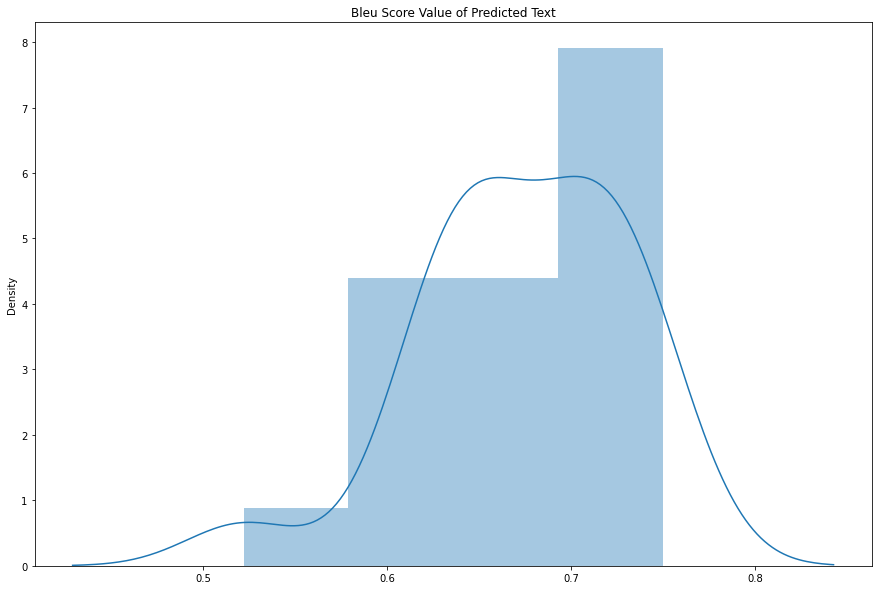

In [ ]:

plt.pyplot.figure(figsize=(15,10))
sns.distplot(list_of_bleu_score)
plt.pyplot.title("Bleu Score Value of Predicted Text")
plt.pyplot.show()

From the above plot we can observe that majority of bleu score are in the range of 0.65 to 0.75

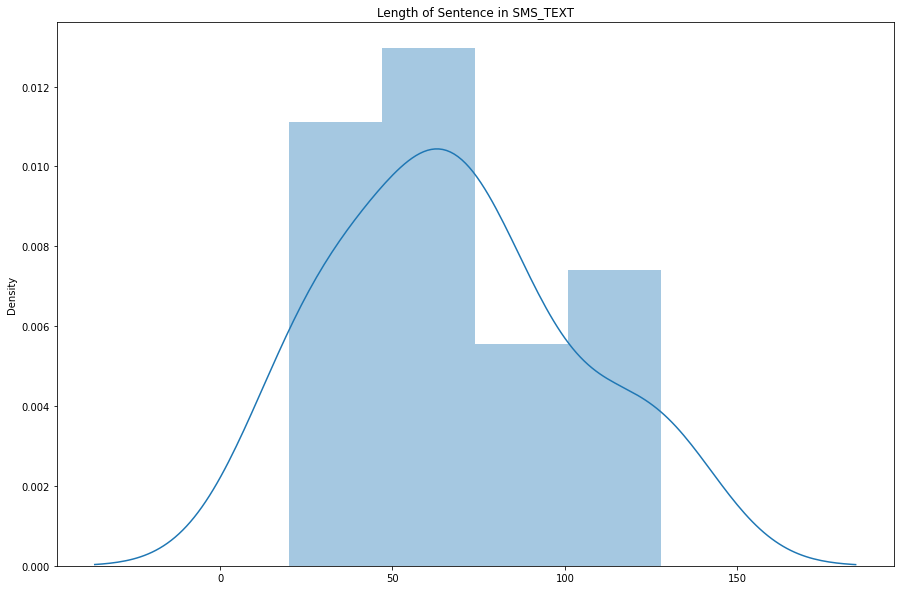

In [ ]:
"""This function calculates the length of sentence."""
def calculating_length_of_sentence_with_spaces(data):
    length_of_sentence=[]
    for index in range(len(data)):
        length_of_sentence.append(len(data.iloc[index]))
    return length_of_sentence    
        
sms_text_length=calculating_length_of_sentence_with_spaces(test_data['SMS_TEXT'])
plt.pyplot.figure(figsize=(15,10))
sns.distplot(sms_text_length)
plt.pyplot.title("Length of Sentence in SMS_TEXT")
plt.pyplot.show()

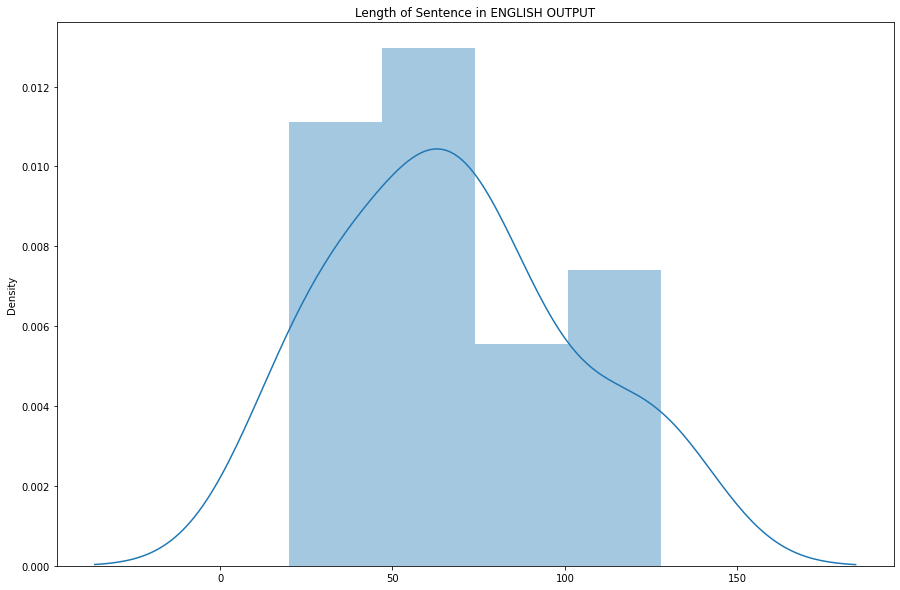

In [ ]:
eng_text_length=calculating_length_of_sentence_with_spaces(test_data['ENGLISH_OUTPUT'])
plt.pyplot.figure(figsize=(15,10))
sns.distplot(sms_text_length)
plt.pyplot.title("Length of Sentence in ENGLISH OUTPUT")
plt.pyplot.show()

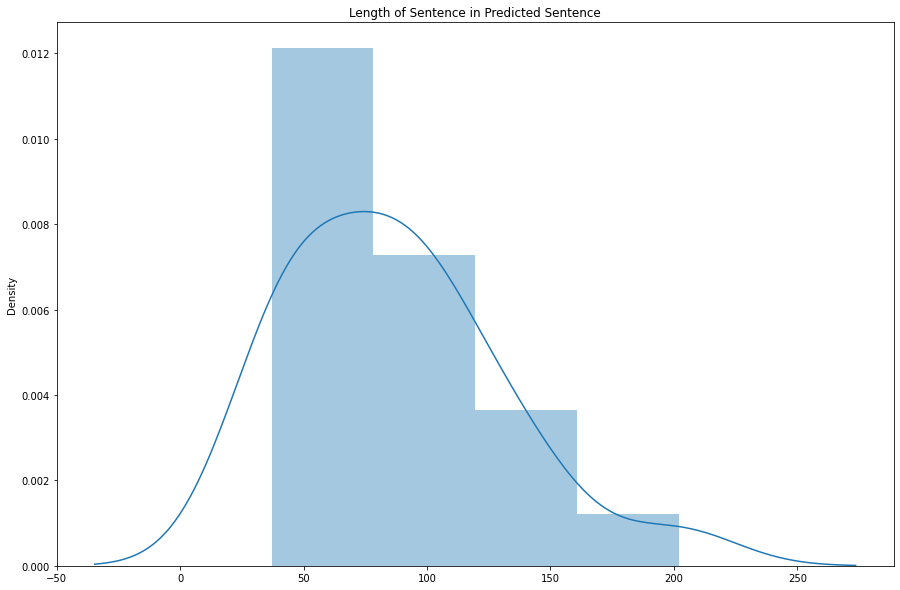

In [ ]:
def length_of_predicted_sentence(data):
    length=[]
    for index in range(len(data)):
        length.append(len(data[index]))
    return length
predicted_sentence_length=length_of_predicted_sentence(predicted_sentence)
plt.pyplot.figure(figsize=(15,10))
sns.distplot(predicted_sentence_length)
plt.pyplot.title("Length of Sentence in Predicted Sentence")
plt.pyplot.show()

Most of the predicted sentences are of length between 50-125. Only one predicted sentence has the length of 202 which is our maximum length

In [ ]:
for index in range(len(test_data)):
    print('*'*100)
    print("Length of SMS_TEXT ",len(test_data['SMS_TEXT'].iloc[index]))
    print("Length of ENGLISH OUTPUT ",len(test_data['ENGLISH_OUTPUT'].iloc[index]))
    print("Length of predicted sentence ",len(predicted_sentence[index]))
    print("Bleu Score ",list_of_bleu_score[index])

****************************************************************************************************
Length of SMS_TEXT  51
Length of ENGLISH OUTPUT  68
Length of predicted sentence  48
Bleu Score  0.7213989879855205
****************************************************************************************************
Length of SMS_TEXT  128
Length of ENGLISH OUTPUT  144
Length of predicted sentence  124
Bleu Score  0.6337268058487422
****************************************************************************************************
Length of SMS_TEXT  21
Length of ENGLISH OUTPUT  23
Length of predicted sentence  75
Bleu Score  0.6324555320336759
****************************************************************************************************
Length of SMS_TEXT  22
Length of ENGLISH OUTPUT  33
Length of predicted sentence  40
Bleu Score  0.6887246539984299
****************************************************************************************************
Length of SMS_TEXT  71
Lengt

When the length of Sms text or english output and predicted sentence of model has huge difference, bleu score is very low. When the predicted sentence length is almost similar to length of sms text or english output,it has good bleu score.
From the histogram plot most of the predicted sentences have bleu score between .65-.75. Best bleu score is around .75 while worst bleu score is .52. When the difference in length of sms text and predicted sentence is within 1-3,bleu score is very good.

In [ ]:
list_of_words=[]
for index in range (len(preprocessed_data)):
    list_of_words+=str(preprocessed_data['SMS_TEXT'].iloc[index]).split()

In [ ]:
words_occurence_sms={}
for words in set(list_of_words):
    words_occurence_sms[words]=list_of_words.count(words)


In [ ]:
sms_sorted_dict={k: v for k, v in sorted(words_occurence_sms.items(), key=lambda item: item[1])}

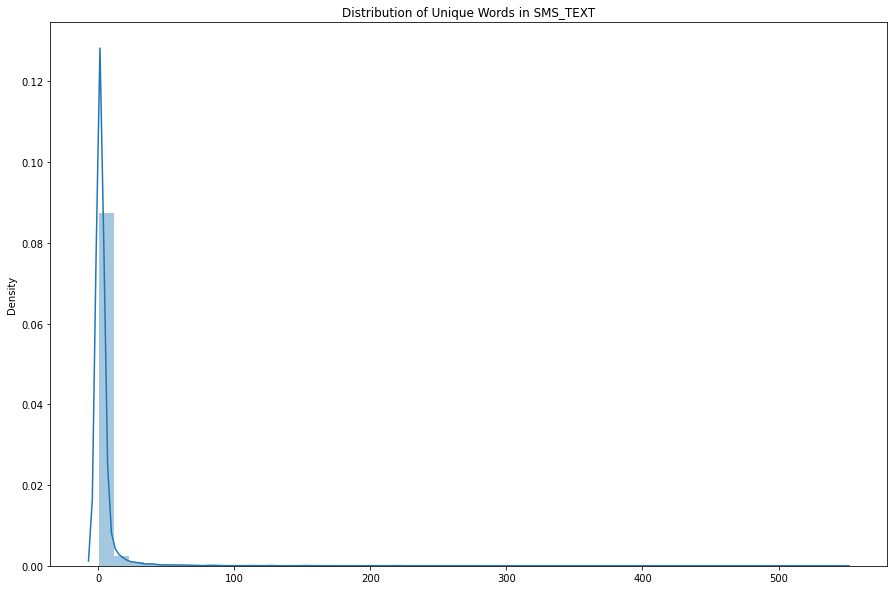

In [ ]:
plt.pyplot.figure(figsize=(15,10))
sns.distplot(list(sms_sorted_dict.values()))
plt.pyplot.title("Distribution of Unique Words in SMS_TEXT")
plt.pyplot.show()

From the above plot we can observe that most of the words in the preprocessed data are unique or rare when words are case sensitive. Highest Frequency of the word is nearly 600. Most of the words have frequency 1.

In [ ]:
eng_list_of_words=[]
for index in range (len(preprocessed_data)):
    eng_list_of_words+=str(preprocessed_data['ENGLISH_OUTPUT'].iloc[index]).split()

In [ ]:
words_occurence_eng={}
for words in set(eng_list_of_words):
    words_occurence_eng[words]=eng_list_of_words.count(words)


In [ ]:
eng_sorted_dict={k: v for k, v in sorted(words_occurence_eng.items(), key=lambda item: item[1])}

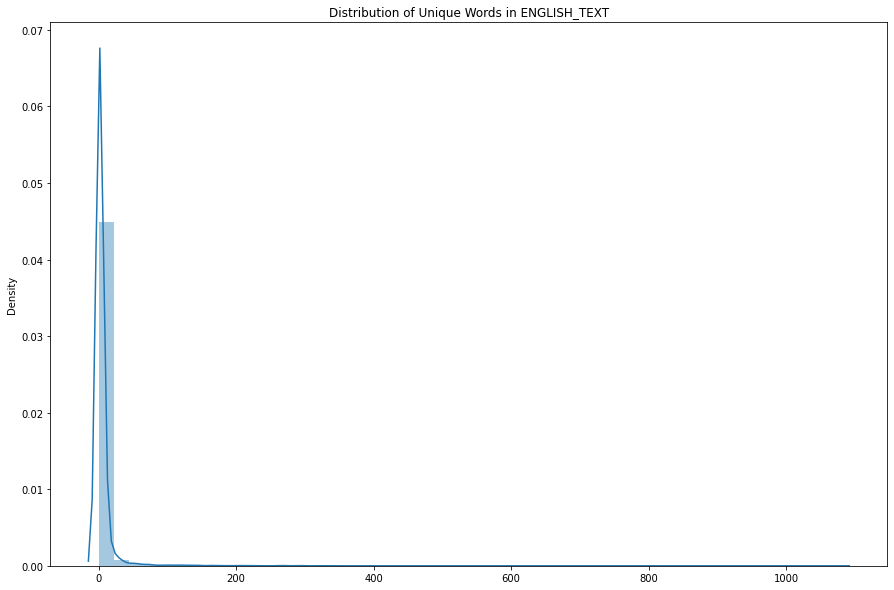

In [ ]:
plt.pyplot.figure(figsize=(15,10))
sns.distplot(list(eng_sorted_dict.values()))
plt.pyplot.title("Distribution of Unique Words in ENGLISH_TEXT")
plt.pyplot.show()

From the above plot we can observe that most of the words in the English Output are unique. Highest Frequnecy is around 1100.

Frequency of words with Highest Bleu Score

In [ ]:
words_with_high_bleu_score={}
for words in str(test_data['SMS_TEXT'].iloc[18]).split():
    words_with_high_bleu_score[words]=sms_sorted_dict[words]
print(words_with_high_bleu_score)

{'Yup...': 16, 'I': 299, 'will': 86, 'be': 74, 'going': 62, 'with': 46, 'my': 203, 'hall.': 1}


In [ ]:
eng_words_with_high_bleu_score={}
for words in str(test_data['ENGLISH_OUTPUT'].iloc[18]).split():
    eng_words_with_high_bleu_score[words]=eng_sorted_dict[words]
print(eng_words_with_high_bleu_score)

{'Yes.': 52, 'I': 1076, 'will': 138, 'be': 146, 'going': 126, 'with': 131, 'my': 205, 'hall.': 2}


Frequency of words with lowest Bleu Score

In [ ]:
words_with_low_bleu_score={}
for words in str(test_data['SMS_TEXT'].iloc[8]).split():
    words_with_low_bleu_score[words]=sms_sorted_dict[words]
print(words_with_low_bleu_score)

{'Hey': 102, 'yijue': 1, 'how': 53, 'are': 60, 'u': 544, 'getting': 2, 'there': 40, 'later....': 1, 'We': 36, 'meeting': 12, 'at': 235, '730': 2, 'orchard': 13, 'mrt.': 2}


In [ ]:
eng_words_with_low_bleu_score={}
for words in str(test_data['ENGLISH_OUTPUT'].iloc[8]).split():
    eng_words_with_low_bleu_score[words]=eng_sorted_dict[words]
print(eng_words_with_low_bleu_score)

{'Hey': 42, 'Yijue,': 2, 'how': 55, 'are': 329, 'you': 1011, 'getting': 9, 'there': 47, 'later?': 11, 'We': 50, 'meeting': 14, 'at': 268, '7:30': 3, 'Orchard': 13, 'MRT.': 5}


In [ ]:
bleu_score_list=load('/content/bleu_score_list.joblib')
print(bleu_score_list)

[0.7213989879855205, 0.6337268058487422, 0.6324555320336759, 0.6887246539984299, 0.609068571773428, 0.6437295293874392, 0.711002833752044, 0.634395177463988, 0.5220173917766389, 0.6992922471483762, 0.697613262053043, 0.6640471006217092, 0.6321808498702935, 0.7234804230870479, 0.7186082239261684, 0.7482317330703532, 0.6597618889159991, 0.6588303014746784, 0.749634235443537, 0.7384102902900735]


In [ ]:
for index in range (len(test_data)):
    print('*'*200)
    sms_words_dictionary={}
    eng_words_dictionary={}
    for words in str(test_data['SMS_TEXT'].iloc[index]).split():
        sms_words_dictionary[words]=sms_sorted_dict[words]
    for words1 in str(test_data['ENGLISH_OUTPUT'].iloc[index]).split():
        eng_words_dictionary[words1]=eng_sorted_dict[words1]
    print("Frequency of words in SMS_TEXT")    
    print(sms_words_dictionary)
    print("Frequency of words in ENGLISH_OUTPUT")
    print(eng_words_dictionary)
    print("Bleu Score")
    print(bleu_score_list[index])        




********************************************************************************************************************************************************************************************************
Frequency of words in SMS_TEXT
{'Ya...Dat': 1, 'dae': 2, 'i': 441, 'check': 9, 'dun': 71, 'haf...So': 1, 'how?': 8, 'Where': 25, 'u': 544, 'wan?': 3}
Frequency of words in ENGLISH_OUTPUT
{'Yeah.': 9, 'That': 13, 'day': 26, 'I': 1076, 'checked,': 1, 'did': 38, 'not': 139, 'have.': 6, 'So': 129, 'how?': 9, 'Where': 33, 'do': 101, 'you': 1011, 'want?': 7}
Bleu Score
0.7213989879855205
********************************************************************************************************************************************************************************************************
Frequency of words in SMS_TEXT
{'I': 299, 'thk': 26, 'u': 544, 'can,': 4, 'juz': 40, 'get': 60, 'e': 172, 'add': 5, 'from': 34, 'ur': 128, 'frens': 11, 'first': 19, 'lor...': 84, 'Haha,': 26, 'i': 441, 'did': 23, 

In [ ]:
sms_text_test_data=[]
for index in range (len(test_data)):
    sms_text_test_data+=str(test_data['SMS_TEXT'].iloc[index]).split()


In [ ]:
words_in_sms_test={}
for words in set(sms_text_test_data):
    words_in_sms_test[words]=sms_sorted_dict[words]

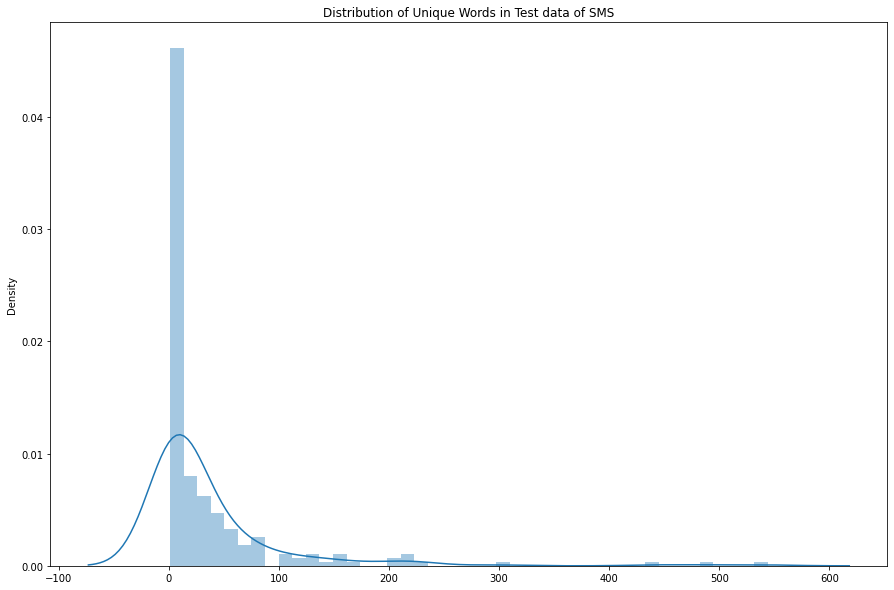

In [ ]:
plt.pyplot.figure(figsize=(15,10))
sns.distplot(list(words_in_sms_test.values()))
plt.pyplot.title("Distribution of Unique Words in Test data of SMS")
plt.pyplot.show()

In [ ]:
eng_text_test_data=[]
for index in range (len(test_data)):
    eng_text_test_data+=str(test_data['ENGLISH_OUTPUT'].iloc[index]).split()


In [ ]:
words_in_eng_test={}
for words in set(eng_text_test_data):
    words_in_eng_test[words]=eng_sorted_dict[words]

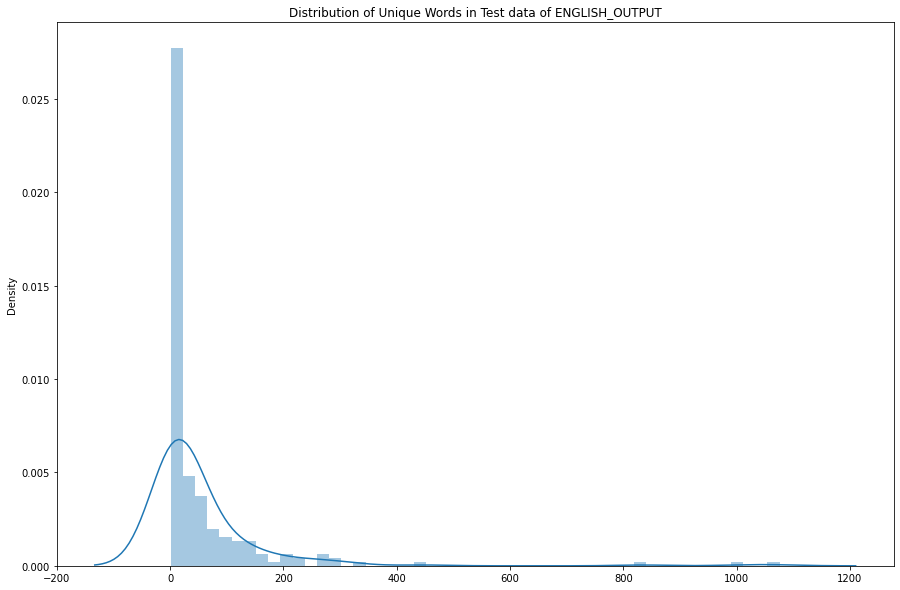

In [ ]:
plt.pyplot.figure(figsize=(15,10))
sns.distplot(list(words_in_eng_test.values()))
plt.pyplot.title("Distribution of Unique Words in Test data of ENGLISH_OUTPUT")
plt.pyplot.show()

In [ ]:
from prettytable import PrettyTable
rare_words_in_sms_text=[6,5,1,1,5,7,8,12,5,5,6,10,9,7,2,7,6,2,1,4]
rare_words_in_eng_text=[5,7,0,0,4,4,6,9,3,5,4,10,8,7,2,5,7,3,1,3]
x = PrettyTable()
x.title='Validation Data'
x.add_column("Bleu Score",bleu_score_list)
x.add_column("Number of Rare words in SMS Text",rare_words_in_sms_text)
x.add_column("Number of Rare words in English Text",rare_words_in_eng_text)
x.sortby = "Bleu Score"
print(x)

+----------------------------------------------------------------------------------------------+
|                                       Validation Data                                        |
+--------------------+----------------------------------+--------------------------------------+
|     Bleu Score     | Number of Rare words in SMS Text | Number of Rare words in English Text |
+--------------------+----------------------------------+--------------------------------------+
| 0.5220173917766389 |                5                 |                  3                   |
| 0.609068571773428  |                5                 |                  4                   |
| 0.6321808498702935 |                9                 |                  8                   |
| 0.6324555320336759 |                1                 |                  0                   |
| 0.6337268058487422 |                5                 |                  7                   |
| 0.634395177463988  |        

Here, I have counted rare words in validation dataset whose frequency in dataset is less than or equal to 10. Our bleu score does not vary based on presence of number of rare words in the text.There are some text whose bleu score is high and have many rare words in comparsion to rare words present in text with lowest bleu score in both sms and english text.